# SSD300 Inference for LEaf Detect



In [2]:
from keras import backend as K
from keras.models import load_model
from keras.preprocessing import image
from keras.optimizers import Adam
from imageio import imread
import numpy as np
from matplotlib import pyplot as plt

from models.keras_ssd7 import build_model
from keras_loss_function.keras_ssd_loss import SSDLoss
from keras_layers.keras_layer_AnchorBoxes import AnchorBoxes
from keras_layers.keras_layer_DecodeDetections import DecodeDetections
from keras_layers.keras_layer_DecodeDetectionsFast import DecodeDetectionsFast
from keras_layers.keras_layer_L2Normalization import L2Normalization

from ssd_encoder_decoder.ssd_output_decoder import decode_detections, decode_detections_fast

from data_generator.object_detection_2d_data_generator import DataGenerator
from data_generator.object_detection_2d_photometric_ops import ConvertTo3Channels
from data_generator.object_detection_2d_geometric_ops import Resize
from data_generator.object_detection_2d_misc_utils import apply_inverse_transforms

%matplotlib inline

Using TensorFlow backend.


In [3]:
# Set the image size.
# Set a few configuration parameters.
img_height = 256
img_width = 256
n_classes = 31
model_mode = 'inference'
img_height = 256 # Height of the input images
img_width = 256 # Width of the input images
img_channels = 3 # Number of color channels of the input images
intensity_mean = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
intensity_range = 127.5 # Set this to your preference (maybe `None`). The current settings transform the input pixel values to the interval `[-1,1]`.
n_classes = 31 # Number of positive classes
scales = [0.08, 0.16, 0.32, 0.64, 0.96] # An explicit list of anchor box scaling factors. If this is passed, it will override `min_scale` and `max_scale`.
aspect_ratios = [0.5, 1.0, 2.0] # The list of aspect ratios for the anchor boxes
two_boxes_for_ar1 = True # Whether or not you want to generate two anchor boxes for aspect ratio 1
steps = None # In case you'd like to set the step sizes for the anchor box grids manually; not recommended
offsets = None # In case you'd like to set the offsets for the anchor box grids manually; not recommended
clip_boxes = True # Whether or not to clip the anchor boxes to lie entirely within the image boundaries
variances = [1.0, 1.0, 1.0, 1.0] # The list of variances by which the encoded target coordinates are scaled
normalize_coords = True # Whether or not the model is supposed to use coordinates relative to the image size


print("done")

done


## 1. Load a trained SSD

Either load a trained model or build a model and load trained weights into it. Since the HDF5 files I'm providing contain only the weights for the various SSD versions, not the complete models, you'll have to go with the latter option when using this implementation for the first time. You can then of course save the model and next time load the full model directly, without having to build it.

You can find the download links to all the trained model weights in the README.

### 1.1. Build the model and load trained weights into it

In [4]:
# 1: Build the Keras model

K.clear_session() # Clear previous models from memory.

model = build_model(image_size=(img_height, img_width, img_channels),
                    n_classes=n_classes,
                    mode='inference',
                    l2_regularization=0.0005,
                    scales=scales,
                    aspect_ratios_global=aspect_ratios,
                    aspect_ratios_per_layer=None,
                    two_boxes_for_ar1=two_boxes_for_ar1,
                    steps=steps,
                    offsets=offsets,
                    clip_boxes=clip_boxes,
                    variances=variances,
                    normalize_coords=normalize_coords,
                    subtract_mean=intensity_mean,
                    divide_by_stddev=intensity_range)

# 2: Optional: Load some weights

#model.load_weights('./ssd7_weights.h5', by_name=True)

#weights_path = 'VGG_ILSVRC_16_layers_fc_reduced.h5'

weights_path = 'ssd7_leaf31_epoch-95.h5'


model.load_weights(weights_path, by_name=True)

# 3: Instantiate an Adam optimizer and the SSD loss function and compile the model

adam = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)

ssd_loss = SSDLoss(neg_pos_ratio=3, alpha=1.0)

model.compile(optimizer=adam, loss=ssd_loss.compute_loss)

model.summary()

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.
Instructions for updating:
Use tf.cast instead.
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
identity_layer (Lambda)         (None, 256, 256, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
input_mean_normalization (Lambd (None, 256, 256, 3)  0           identity_layer[0][0]             
__________________________________________________________________________________________________
input_stddev_normalization (Lam (None, 2

Or

### 1.2. Load a trained model

## 2. Load some images

Load some images for which you'd like the model to make predictions.

In [20]:
from keras.applications.imagenet_utils import preprocess_input
orig_images = [] # Store the images here.
input_images = [] # Store resized versions of the images here.

# We'll only load one image in this example.img_path = 'Potato_Early_blight_masked_27937.jpg'

#img_path = 'Apple_scab_masked_1164.jpg'

#img_path = 'Potato_Early_blight_masked_27937.jpg'

img_path = 'test_pic.jpg'

orig_images.append(imread(img_path))
img = image.load_img(img_path, target_size=(256, 256))
img = image.img_to_array(img) 
input_images.append(img)
input_images = np.array(input_images)

inputs = []
images = []
img_path = 'test_pic.jpg'
img = image.load_img(img_path, target_size=(256, 256))
img = image.img_to_array(img)
images.append(imread(img_path))
inputs.append(img.copy())
inputs = preprocess_input(np.array(inputs))

## 3. Make predictions

In [21]:
y_pred = model.predict(inputs)

`y_pred` contains a fixed number of predictions per batch item (200 if you use the original model configuration), many of which are low-confidence predictions or dummy entries. We therefore need to apply a confidence threshold to filter out the bad predictions. Set this confidence threshold value how you see fit.

In [22]:
confidence_threshold = 0.5

y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh[0])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  4.     0.81  10.11 -19.24 245.16 230.95]]


## 4. Visualize the predictions

We just resized the input image above and made predictions on the distorted image. We'd like to visualize the predictions on the image in its original size though, so below we'll transform the coordinates of the predicted boxes accordingly.

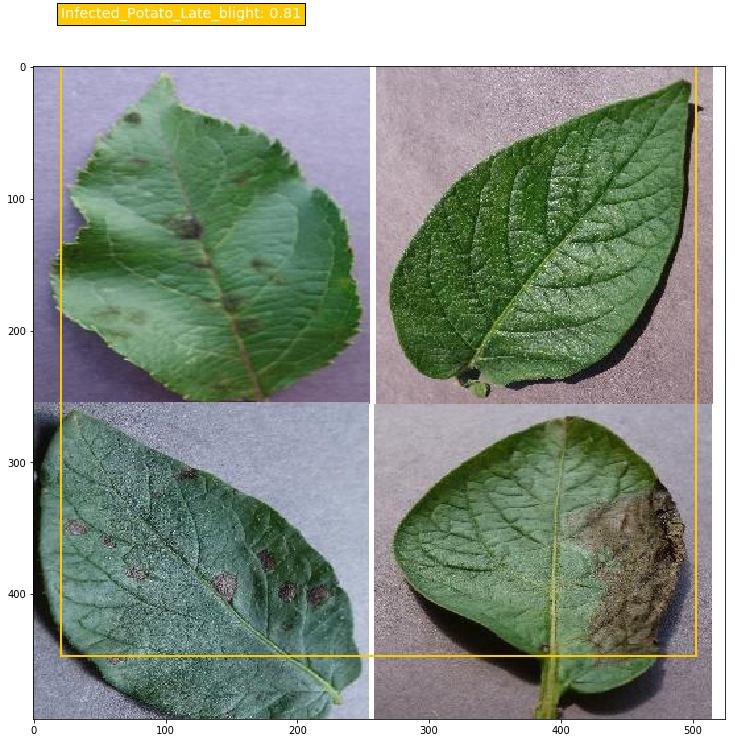

In [23]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 31)).tolist()


classes = [ 'background',
            'Potato_healthy',
            'Infected_Potato_Early_blight',
            'Potato_Early_blight',
            'Infected_Potato_Late_blight',
            'Potato_Late_blight',
            'Tomato_healthy',
            'Infected_Tomato_Septoria_spot',
            'Tomato_Septoria_spot',
            'Infected_Tomato_Spider_mites',
            'Tomato_Spider_mites',
            'Infected_Tomato_Target_Spot',
            'Tomato_Target_Spot',
            'Infected_Tomato_Curl_Virus',
            'Tomato_Curl_Virus',
            'Infected_Tomato_mosaic_virus',
            'Tomato_mosaic_virus',
            'Infected_Tomato_Leaf_Mold',
            'Tomato_Leaf_Mold',
            'Infected_Tomato_Bacterial_spot',
            'Tomato_Bacterial_spot',
            'Infected_Tomato_Early_blight',
            'Tomato_Early_blight',
            'Infected_Tomato_Late_blight',
            'Tomato_Late_blight',
            'Corn_healthy',
            'Infected_Corn_Common_rust',
            'Corn_Common_rust',
            'Infected_Corn_Gray_leaf',
            'Corn_Gray_leaf',
            'Infected_Corn_Northern_Blight',
            'Corn_Northern_Blight'
    
]

plt.figure(figsize=(20,12))
plt.imshow(orig_images[0])

current_axis = plt.gca()

for box in y_pred_thresh[0]:
    # Transform the predicted bounding boxes for the 300x300 image to the original image dimensions.
    xmin = box[2] * orig_images[0].shape[1] / img_width
    ymin = box[3] * orig_images[0].shape[0] / img_height
    xmax = box[4] * orig_images[0].shape[1] / img_width
    ymax = box[5] * orig_images[0].shape[0] / img_height
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})

## 5. Make predictions on Pascal VOC 2007 Test

Let's use a `DataGenerator` to make predictions on the Pascal VOC 2007 test dataset and visualize the predicted boxes alongside the ground truth boxes for comparison. Everything here is preset already, but if you'd like to learn more about the data generator and its capabilities, take a look at the detailed tutorial in [this](https://github.com/pierluigiferrari/data_generator_object_detection_2d) repository.

In [30]:
# Create a `BatchGenerator` instance and parse the Pascal VOC labels.

dataset = DataGenerator()

# TODO: Set the paths to the datasets here.

VOC_2019_images_dir      = '/hdd/data/LeafDetectData/LEAF2019/JPEGImages/'

VOC_2019_annotations_dir      = '/hdd/data/LeafDetectData/LEAF2019/Annotations/'

VOC_2019_test_image_set_filename     = '/hdd/data/LeafDetectData/LEAF2019/ImageSets/Main/test.txt'

#classes = ['background','Potato_healthy','Potato_Early_blight','Infected_Potato_Early_blight',
#           'Potato_Late_blight','Infected_Potato_Late_blight','Tomato_healthy',
#           'Tomato_Early_blight','Infected_Tomato_Early_blight','Tomato_Late_blight','Infected_Tomato_Late_blight']

classes = [ 'background',
            'Potato_healthy',
            'Infected_Potato_Early_blight',
            'Potato_Early_blight',
            'Infected_Potato_Late_blight',
            'Potato_Late_blight',
            'Tomato_healthy',
            'Infected_Tomato_Septoria_spot',
            'Tomato_Septoria_spot',
            'Infected_Tomato_Spider_mites',
            'Tomato_Spider_mites',
            'Infected_Tomato_Target_Spot',
            'Tomato_Target_Spot',
            'Infected_Tomato_Curl_Virus',
            'Tomato_Curl_Virus',
            'Infected_Tomato_mosaic_virus',
            'Tomato_mosaic_virus',
            'Infected_Tomato_Leaf_Mold',
            'Tomato_Leaf_Mold',
            'Infected_Tomato_Bacterial_spot',
            'Tomato_Bacterial_spot',
            'Infected_Tomato_Early_blight',
            'Tomato_Early_blight',
            'Infected_Tomato_Late_blight',
            'Tomato_Late_blight',
            'Corn_healthy',
            'Infected_Corn_Common_rust',
            'Corn_Common_rust',
            'Infected_Corn_Gray_leaf',
            'Corn_Gray_leaf',
            'Infected_Corn_Northern_Blight',
            'Corn_Northern_Blight'
    
]





dataset.parse_xml(images_dirs=[VOC_2019_images_dir],
                  image_set_filenames=[VOC_2019_test_image_set_filename],
                  annotations_dirs=[VOC_2019_annotations_dir],
                  classes=classes,
                  include_classes='all',
                  exclude_truncated=False,
                  exclude_difficult=True,
                  ret=False)

convert_to_3_channels = ConvertTo3Channels()
resize = Resize(height=img_height, width=img_width)

generator = dataset.generate(batch_size=1,
                             shuffle=True,
                             transformations=[convert_to_3_channels,
                                              resize],
                             returns={'processed_images',
                                      'filenames',
                                      'inverse_transform',
                                      'original_images',
                                      'original_labels'},
                             keep_images_without_gt=False)


Processing image set 'test.txt': 100%|██████████| 678/678 [00:03<00:00, 185.78it/s]

In [31]:
# Generate a batch and make predictions.

batch_images, batch_filenames, batch_inverse_transforms, batch_original_images, batch_original_labels = next(generator)

i = 0 # Which batch item to look at

print("Image:", batch_filenames[i])
print()
print("Ground truth boxes:\n")
print(np.array(batch_original_labels[i]))

Image: /hdd/data/LeafDetectData/LEAF2019/JPEGImages/Potato_Early_blight_masked_27842.jpg

Ground truth boxes:

[[  2  10  16 241 247]
 [  3  95 130 144 168]
 [  3 144  84 200 124]
 [  3  22  87  80 133]
 [  3 152 161 212 207]
 [  3 106 173 134 199]]


In [32]:
# Predict.

y_pred = model.predict(batch_images, batch_size=1 , verbose =1)

1/1 [==============================] - 0s 129ms/step


In [33]:
confidence_threshold = 0.5

# Perform confidence thresholding.
y_pred_thresh = [y_pred[k][y_pred[k,:,1] > confidence_threshold] for k in range(y_pred.shape[0])]

# Convert the predictions for the original image.
y_pred_thresh_inv = apply_inverse_transforms(y_pred_thresh, batch_inverse_transforms)

np.set_printoptions(precision=2, suppress=True, linewidth=90)
print("Predicted boxes:\n")
print('   class   conf xmin   ymin   xmax   ymax')
print(y_pred_thresh_inv[i])

Predicted boxes:

   class   conf xmin   ymin   xmax   ymax
[[  2.     1.    27.    21.   222.   237.  ]
 [  3.     0.93 147.   156.   210.   210.  ]
 [  3.     0.86  31.    93.    83.   144.  ]
 [  3.     0.8  150.    83.   204.   132.  ]
 [  3.     0.73  97.   131.   144.   168.  ]]


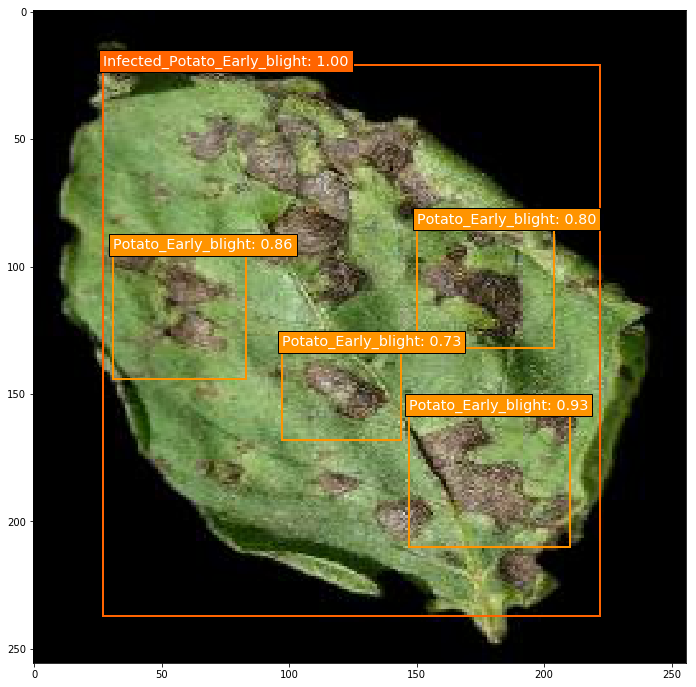

In [34]:
# Display the image and draw the predicted boxes onto it.

# Set the colors for the bounding boxes
colors = plt.cm.hsv(np.linspace(0, 1, 31)).tolist()

plt.figure(figsize=(20,12))
plt.imshow(batch_original_images[i])

current_axis = plt.gca()

for box in batch_original_labels[i]:
    xmin = box[1]
    ymin = box[2]
    xmax = box[3]
    ymax = box[4]
    label = '{}'.format(classes[int(box[0])])
   # current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color='green', fill=False, linewidth=2))  
   # current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':'green', 'alpha':1.0})

for box in y_pred_thresh_inv[i]:
    xmin = box[2]
    ymin = box[3]
    xmax = box[4]
    ymax = box[5]
    color = colors[int(box[0])]
    label = '{}: {:.2f}'.format(classes[int(box[0])], box[1])
    current_axis.add_patch(plt.Rectangle((xmin, ymin), xmax-xmin, ymax-ymin, color=color, fill=False, linewidth=2))  
    current_axis.text(xmin, ymin, label, size='x-large', color='white', bbox={'facecolor':color, 'alpha':1.0})